In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
from dichotomous_multiplication_model_functions import *

In [3]:
index_cols=['location_id','sex_id','age_group_id']

age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8,1]
years = [2021,2022,2023,2024,2025]

In [4]:
# vitamin A specific -- these should be replaced for other models
rei_id = 97
cause_ids = [302]
nonfatal_causes = []
nutrient = 'zinc'
vehicle = 'wheat flour'

#effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

data = pd.read_csv(
        '/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
location_ids = list(data.loc[data.nutrient==nutrient].loc[data.vehicle==vehicle].location_id.unique())

"""Note: full set of location IDs is shown below, but subset used here
was selected because they are the locations with non-missing coverage data
for the nutrient and vehicle of interest (vitamin A/oil)

[168, 161, 201, 202, 6, 205, 171, 141, 179, 207, 163, 11, 180, 181,
184, 15, 164, 213, 214, 165, 196, 522, 190, 189, 20]"""

location_ids = [163, 214]

In [5]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 0.47
q_975 = 0.69

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [6]:
baseline_coverage, counterfactual_coverage = generate_overall_coverage_rates(nutrient, 
                                                                             vehicle,
                                                                             coverage_levels,
                                                                             years,
                                                                             location_ids)

In [7]:
rr_deficiency_nofort = (1 / generate_rr_deficiency_nofort_draws(mu, sigma, location_ids))
rr_deficiency_nofort.mean(axis=1)

location_id
163    2.178029
214    2.178029
dtype: float64

In [8]:
1 / 0.17

5.88235294117647

In [9]:
paf_dalys_deficiency = pull_cause_specific_dalys_deficiency_pafs(rei_id, 
                                                                 cause_ids, 
                                                                 location_ids, 
                                                                 age_group_ids, 
                                                                 sex_ids, 
                                                                 index_cols)
paf_dalys_deficiency.head()

draw_0    draw_1   draw_10  \
location_id sex_id age_group_id cause_id                                 
163         1      5            302       0.019833  0.007751  0.012343   
            2      5            302       0.019200  0.008600  0.011429   
214         1      5            302       0.005240  0.000466  0.002833   
            2      5            302       0.005780  0.000249  0.001932   

                                          draw_100  draw_101  draw_102  \
location_id sex_id age_group_id cause_id                                 
163         1      5            302       0.017980  0.007017  0.006222   
            2      5            302       0.014399  0.007092  0.006286   
214         1      5            302       0.005114  0.001241  0.001179   
            2      5            302       0.005149  0.001224  0.000816   

                                          draw_103  draw_104  draw_105  \
location_id sex_id age_group_id cause_id                                 
163         1      5            302       0.008568  0.022292  0.019517   
            2      5            302       0.007430  0.017612  0.023047   
214         1      5            302       0.001461  0.005529  0.008511   
            2      5            302       0.001328  0.005353  0.007091   

                                          draw_106  ...  draw_990  draw_991  \
location_id sex_id age_group_id cause_id            ...                       
163         1      5            302       0.023808  ...  0.018676  0.031475   
            2      5            302       0.011789  ...  0.017519  0.027390   
214         1      5            302       0.003140  ...  0.005245  0.013181   
            2      5            302       0.002897  ...  0.005011  0.012797   

                                          draw_992  draw_993  draw_994  \
location_id sex_id age_group_id cause_id                                 
163         1      5            302       0.018728  0.021847  0.039727   
            2      5            302       0.014410  0.019353  0.041237   
214         1      5            302       0.002853  0.005726  0.017077   
            2      5            302       0.002961  0.005691  0.016250   

                                          draw_995  draw_996  draw_997  \
location_id sex_id age_group_id cause_id                                 
163         1      5            302       0.024383  0.019326  0.017907   
            2      5            302       0.022533  0.020284  0.014590   
214         1      5            302       0.011714  0.006877  0.003669   
            2      5            302       0.010778  0.005695  0.004294   

                                          draw_998  draw_999  
location_id sex_id age_group_id cause_id                      
163         1      5            302       0.017974  0.021542  
            2      5            302       0.015057  0.018881  
214         1      5            302       0.004821  0.008391  
            2      5            302       0.004491  0.008643  

[4 rows x 1000 columns]

In [10]:
dalys = pull_dalys(cause_ids,
                   nonfatal_causes,
                   location_ids, 
                   age_group_ids, 
                   sex_ids, 
                   index_cols)
dalys.head()

draw_0        draw_1  \
location_id sex_id age_group_id cause_id                               
163         1      2            302       2.280523e+05  2.564597e+05   
                   3            302       2.076096e+05  2.630785e+05   
                   4            302       1.225690e+06  1.189050e+06   
                   5            302       8.546076e+05  7.471064e+05   
            2      2            302       2.379659e+05  2.066670e+05   

                                                draw_10      draw_100  \
location_id sex_id age_group_id cause_id                                
163         1      2            302       146290.339705  1.926764e+05   
                   3            302       198861.237612  1.736386e+05   
                   4            302       775940.176172  1.307441e+06   
                   5            302       580438.053849  5.582382e+05   
            2      2            302       244817.650638  3.455781e+05   

                                               draw_101       draw_102  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       172362.436243  187454.984499   
                   3            302       255710.254455  184070.329711   
                   4            302       966519.474530  912323.385899   
                   5            302       647614.097767  516339.545964   
            2      2            302       266118.812469  177796.115815   

                                              draw_103      draw_104  \
location_id sex_id age_group_id cause_id                               
163         1      2            302       1.595342e+05  1.762358e+05   
                   3            302       1.674592e+05  2.827097e+05   
                   4            302       1.043619e+06  1.075921e+06   
                   5            302       6.581249e+05  8.600843e+05   
            2      2            302       2.126383e+05  2.776451e+05   

                                              draw_105       draw_106  ...  \
location_id sex_id age_group_id cause_id                               ...   
163         1      2            302       1.704897e+05  151586.434309  ...   
                   3            302       2.285264e+05  190682.116226  ...   
                   4            302       1.135655e+06  975816.038468  ...   
                   5            302       6.413578e+05  602330.349077  ...   
            2      2            302       2.243898e+05  233633.518800  ...   

                                              draw_990       draw_991  \
location_id sex_id age_group_id cause_id                                
163         1      2            302       2.337282e+05  195240.822126   
                   3            302       2.663606e+05  251853.188296   
                   4            302       1.136730e+06  929957.977163   
                   5            302       8.500877e+05  658930.485588   
            2      2            302       3.131480e+05  155591.679152   

                                              draw_992      draw_993  \
location_id sex_id age_group_id cause_id                               
163         1      2            302       2.647678e+05  1.898549e+05   
                   3            302       2.502901e+05  1.896217e+05   
                   4            302       1.170668e+06  1.033989e+06   
                   5            302       7.432893e+05  6.711235e+05   
            2      2            302       1.938960e+05  1.828121e+05   

                                              draw_994      draw_995  \
location_id sex_id age_group_id cause_id                               
163         1      2            302       2.012600e+05  2.468178e+05   
                   3            302       2.269387e+05  2.900916e+05   
                   4            302       1.050980e+06  1.163305e+06   
                   5            302       6.703140e+05  9.036159e+05   
           

In [11]:
paf_deficiency_nofort = calculate_paf_deficiency_nofort(rr_deficiency_nofort, 
                                                        baseline_coverage)
paf_deficiency_nofort.head()

draw_0    draw_1   draw_10  draw_100  draw_101  draw_102  \
location_id year                                                               
163         2021  0.332672  0.555191  0.566801  0.590712  0.476914  0.475707   
            2022  0.332672  0.555191  0.566801  0.590712  0.476914  0.475707   
            2023  0.332672  0.555191  0.566801  0.590712  0.476914  0.475707   
            2024  0.332672  0.555191  0.566801  0.590712  0.476914  0.475707   
            2025  0.332672  0.555191  0.566801  0.590712  0.476914  0.475707   

                  draw_103  draw_104  draw_105  draw_106  ...  draw_990  \
location_id year                                          ...             
163         2021  0.628069  0.464427  0.565979  0.361609  ...  0.532567   
            2022  0.628069  0.464427  0.565979  0.361609  ...  0.532567   
            2023  0.628069  0.464427  0.565979  0.361609  ...  0.532567   
            2024  0.628069  0.464427  0.565979  0.361609  ...  0.532567   
            2025  0.628069  0.464427  0.565979  0.361609  ...  0.532567   

                  draw_991  draw_992  draw_993  draw_994  draw_995  draw_996  \
location_id year                                                               
163         2021  0.547902  0.385034  0.329602  0.571065  0.510661  0.459724   
            2022  0.547902  0.385034  0.329602  0.571065  0.510661  0.459724   
            2023  0.547902  0.385034  0.329602  0.571065  0.510661  0.459724   
            2024  0.547902  0.385034  0.329602  0.571065  0.510661  0.459724   
            2025  0.547902  0.385034  0.329602  0.571065  0.510661  0.459724   

                  draw_997  draw_998  draw_999  
location_id year                                
163         2021  0.559401  0.568105   0.57148  
            2022  0.559401  0.568105   0.57148  
            2023  0.559401  0.568105   0.57148  
            2024  0.559401  0.568105   0.57148  
            2025  0.559401  0.568105   0.57148  

[5 rows x 1000 columns]

In [12]:
pif_deficiency_nofort = calculate_pif_deficiency_nofort(paf_deficiency_nofort, 
                                                        baseline_coverage, 
                                                        counterfactual_coverage)

assert np.all(pif_deficiency_nofort <= 1), "ERROR: PIFs above one"

pif_deficiency_nofort.head()

draw_0    draw_1   draw_10  draw_100  \
location_id year coverage_level                                           
163         2021 0.2             0.000000  0.000000  0.000000  0.000000   
                 0.5             0.000000  0.000000  0.000000  0.000000   
                 0.8             0.000000  0.000000  0.000000  0.000000   
                 1.0             0.000000  0.000000  0.000000  0.000000   
            2022 0.2            -0.015217 -0.028557 -0.032321 -0.024611   

                                 draw_101  draw_102  draw_103  draw_104  \
location_id year coverage_level                                           
163         2021 0.2             0.000000  0.000000  0.000000  0.000000   
                 0.5             0.000000  0.000000  0.000000  0.000000   
                 0.8             0.000000  0.000000  0.000000  0.000000   
                 1.0             0.000000  0.000000  0.000000  0.000000   
            2022 0.2            -0.026478 -0.025652 -0.038467 -0.027748   

                                 draw_105  draw_106  ...  draw_990  draw_991  \
location_id year coverage_level                      ...                       
163         2021 0.2             0.000000  0.000000  ...  0.000000  0.000000   
                 0.5             0.000000  0.000000  ...  0.000000  0.000000   
                 0.8             0.000000  0.000000  ...  0.000000  0.000000   
                 1.0             0.000000  0.000000  ...  0.000000  0.000000   
            2022 0.2            -0.025255 -0.020914  ... -0.026697 -0.036166   

                                 draw_992  draw_993  draw_994  draw_995  \
location_id year coverage_level                                           
163         2021 0.2             0.000000   0.00000  0.000000  0.000000   
                 0.5             0.000000   0.00000  0.000000  0.000000   
                 0.8             0.000000   0.00000  0.000000  0.000000   
                 1.0             0.000000   0.00000  0.000000  0.000000   
            2022 0.2            -0.018883  -0.01906 -0.030489 -0.025811   

                                 draw_996  draw_997  draw_998  draw_999  
location_id year coverage_level                                          
163         2021 0.2             0.000000  0.000000   0.00000  0.000000  
                 0.5             0.000000  0.000000   0.00000  0.000000  
                 0.8             0.000000  0.000000   0.00000  0.000000  
                 1.0             0.000000  0.000000   0.00000  0.000000  
            2022 0.2            -0.023753 -0.024602  -0.03044 -0.031803  

[5 rows x 1000 columns]

In [13]:
def duplicate_over_simulation_years(df, years):
    data = df.reset_index()
    data_years = pd.DataFrame()
    for year in years:
        temp = data.copy()
        temp['year'] = year
        data_years = pd.concat([data_years, temp], ignore_index=True)
    data_years = data_years.set_index(['location_id','year','age_group_id','sex_id','cause_id']).sort_index()
    return data_years

In [14]:
def calculate_final_pifs_and_daly_reductions(pif_deficiency_nofort,
                                             paf_dalys_deficiency,
                                             dalys,
                                             coverage_levels, years):
    """This function calcualtes the PIF for fortification on DALYs as well as the
    overall reduction in the number of DALYs at the location, age group, sex,
    year, cause, draw, and coverage level specific level"""

    dalys_prepped = duplicate_over_simulation_years(dalys, years)
    paf_dalys_deficiency_prepped = duplicate_over_simulation_years(paf_dalys_deficiency, years)

    pif_dalys_nofort = pd.DataFrame()
    dalys_reduction = pd.DataFrame()
    for coverage_level in coverage_levels:
        pif_deficiency_nofort_level = (pif_deficiency_nofort.reset_index()
                                       .loc[pif_deficiency_nofort.reset_index().coverage_level == coverage_level]
                                       .drop(columns='coverage_level')
                                       .set_index(['location_id', 'year']))
        pif_dalys_nofort_level = pif_deficiency_nofort_level * paf_dalys_deficiency_prepped
        daly_reduction_level = (pif_dalys_nofort_level.reset_index()
                                .set_index(['location_id','year','sex_id','age_group_id','cause_id']) 
                                * dalys_prepped.reset_index()
                                .set_index(['location_id','year','sex_id','age_group_id','cause_id'])) 

        pif_dalys_nofort_level['coverage_level'] = coverage_level
        daly_reduction_level['coverage_level'] = coverage_level
        pif_dalys_nofort = pd.concat([pif_dalys_nofort, pif_dalys_nofort_level])
        dalys_reduction = pd.concat([dalys_reduction, daly_reduction_level])

    pif_dalys_nofort = (pif_dalys_nofort.reset_index()
                        .set_index([c for c in pif_dalys_nofort.reset_index().columns if 'draw' not in c]))
    daly_reduction = (dalys_reduction.reset_index()
                      .set_index([c for c in dalys_reduction.reset_index().columns if 'draw' not in c])
                      .replace(np.nan, 0))

    return pif_dalys_nofort, daly_reduction

In [15]:
pif_dalys_nofort, daly_reduction = calculate_final_pifs_and_daly_reductions(pif_deficiency_nofort, 
                                             paf_dalys_deficiency, 
                                             dalys, 
                                             coverage_levels,
                                             years)

In [16]:
fort_daly_reduction_by_location = (daly_reduction.groupby(['location_id','coverage_level','year']).sum()
                                   .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
                                   .filter(['mean','2.5%','97.5%']))
    
fort_daly_reduction_by_location

mean         2.5%         97.5%
location_id coverage_level year                                        
163         0.2            2021     0.000000     0.000000      0.000000
                           2022  -844.235042 -2093.643684   -145.049833
                           2023  -844.235042 -2093.643684   -145.049833
                           2024  -844.235042 -2093.643684   -145.049833
                           2025  -844.235042 -2093.643684   -145.049833
            0.5            2021     0.000000     0.000000      0.000000
                           2022  -475.468910 -1187.405757    -83.373733
                           2023  -475.468910 -1187.405757    -83.373733
                           2024  -475.468910 -1187.405757    -83.373733
                           2025  -475.468910 -1187.405757    -83.373733
            0.8            2021     0.000000     0.000000      0.000000
                           2022  -106.702778  -258.789542    -19.272502
                           2023  -106.702778  -258.789542    -19.272502
                           2024  -106.702778  -258.789542    -19.272502
                           2025  -106.702778  -258.789542    -19.272502
            1.0            2021     0.000000     0.000000      0.000000
                           2022   139.141310    22.124636    373.895270
                           2023   139.141310    22.124636    373.895270
                           2024   139.141310    22.124636    373.895270
                           2025   139.141310    22.124636    373.895270
214         0.2            2021     0.000000     0.000000      0.000000
                           2022 -1075.264346 -3758.432613    -16.705663
                           2023 -1075.264346 -3758.432613    -16.705663
                           2024 -1075.264346 -3758.432613    -16.705663
                           2025 -1075.264346 -3758.432613    -16.705663
            0.5            2021     0.000000     0.000000      0.000000
                           2022  2934.387729    49.818161   9366.742335
                           2023  2934.387729    49.818161   9366.742335
                           2024  2934.387729    49.818161   9366.742335
                           2025  2934.387729    49.818161   9366.742335
            0.8            2021     0.000000     0.000000      0.000000
                           2022  6944.039804   119.990841  22729.983405
                           2023  6944.039804   119.990841  22729.983405
                           2024  6944.039804   119.990841  22729.983405
                           2025  6944.039804   119.990841  22729.983405
            1.0            2021     0.000000     0.000000      0.000000
                           2022  9617.141187   166.772627  31534.845516
                           2023  9617.141187   166.772627  31534.845516
                           2024  9617.141187   166.772627  31534.845516
                           2025  9617.141187   166.772627  31534.845516

In [17]:
pop = (get_population(location_id=location_ids,
                    sex_id=sex_ids,
                    age_group_id=age_group_ids,
                    gbd_round_id=6,
                    decomp_step='step4')
       .groupby('location_id').sum())
rates = pop.reset_index().merge(fort_daly_reduction_by_location.reset_index(), on='location_id')
for col in ['mean','2.5%','97.5%']:
    rates[f'{col}'] = rates[f'{col}'] / rates.population * 100_000
rates = rates[['location_id','year','coverage_level','mean','2.5%','97.5%']]
l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]
l = l[['location_id','location_name']]
rates = rates.merge(l, on='location_id')
rates

,location_id,year,coverage_level,mean,2.5%,97.5%,location_name
0,163,2021,0.2,0.000000,0.000000,0.000000,India
1,163,2022,0.2,-0.721132,-1.788357,-0.123899,India
2,163,2023,0.2,-0.721132,-1.788357,-0.123899,India
3,163,2024,0.2,-0.721132,-1.788357,-0.123899,India
4,163,2025,0.2,-0.721132,-1.788357,-0.123899,India
5,163,2021,0.5,0.000000,0.000000,0.000000,India
6,163,2022,0.5,-0.406138,-1.014263,-0.071217,India
7,163,2023,0.5,-0.406138,-1.014263,-0.071217,India
8,163,2024,0.5,-0.406138,-1.014263,-0.071217,India
9,163,2025,0.5,-0.406138,-1.014263,-0.071217,India


In [18]:
# note... want to restructure these plots to bar chart or scatter so that
# it does not appear like we are modeling partial years

def make_plots(location_id):
    plt.figure()
    colors = ['tab:blue','tab:orange','tab:green']

    env = (paf_dalys_deficiency * dalys).groupby('location_id').sum().reset_index()
    env = env.loc[env.location_id==location_id]
    env = env.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
    env['mean'] = env['mean'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
    env['2.5%'] = env['2.5%'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000
    env['97.5%'] = env['97.5%'] / pop.reset_index().loc[pop.reset_index().location_id==location_id]['population'].values * 100_000

    plt.plot(years, [env['mean'].values[0]] * len(years), color='grey')
    plt.fill_between(years, [env['2.5%'].values[0]] * len(years), [env['97.5%'].values[0]] * len(years), color='grey', alpha=0.1)

    for i in list(range(len(coverage_levels) - 1)):
        rate = rates.loc[rates.location_id==location_id]
        rate = rate.loc[rate.coverage_level == coverage_levels[i]]

        plt.plot(rate.year, rate['mean'],color=colors[i])
        plt.fill_between(rate.year, rate['2.5%'], rate['97.5%'], color=colors[i], alpha=0.1)

    location_name = l.loc[l.location_id==location_id]['location_name'].values[0]
    plt.title(f'DALYs Averted Due to Vitamin A Fortification \n Scale-up among Children Under Five in {location_name}')
    plt.xlabel('Year')
    plt.ylabel('DALYs per 100,000 person-years')
    plt.legend(['Total Vitamin A Deficiency Burden','20% coverage','50% coverage','80% coverage'])
    plt.xticks(years)

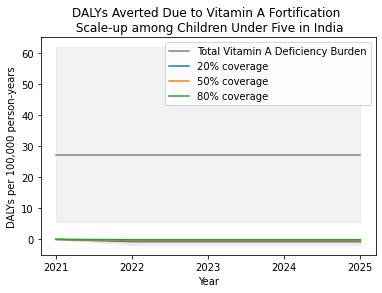

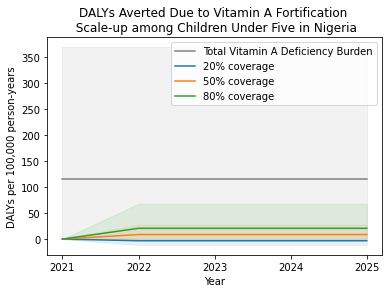

In [19]:
for location_id in location_ids:
    make_plots(location_id)